# Alex Dvorak, Project 7, November 20, 2021

### Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

### Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

### Data Description

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

### Data Dictionary

- **CustomerId**: Unique ID which is assigned to each customer
- **Surname**: Last name of the customer 
- **CreditScore**: It defines the credit history of the customer.  
- **Geography**: A customer’s location    
- **Gender**: It defines the Gender of the customer   
- **Age**: Age of the customer     
- **Tenure**: Number of years for which the customer has been with the bank
- **NumOfProducts**: It refers to the number of products that a customer has purchased through the bank.
- **Balance**: Account balance
- **HasCrCard**: It is a categorical variable that decides whether the customer has a credit card or not.
- **EstimatedSalary**: Estimated salary 
- **isActiveMember**: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
- **Exited**: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values: 0 means the customers did not leave the bank and 1 means the customer left the bank.

In [1]:
# Ignoring Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing General Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Preprocessing Modules and Tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from hyperopt import hp, Trials, tpe, fmin

# Benchmark Model
from xgboost import XGBClassifier

# Tensorflow and Keras
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Metrics
from keras.metrics import *
from sklearn.metrics import *

# Loading and Splitting the Dataset

In [2]:
full_bank_data = pd.read_csv('bank.csv') # retrieving the dataset 
  # Note: the .csv file was uploaded to the session storage of Google Colab and retrieved from there
full_bank_data.head() # showing the columns

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
print(full_bank_data.shape) # what is the shape of the dataset?

(10000, 14)


In [4]:
bank_data = full_bank_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1) 
  # removing the identication columns, these unique features do not contribute to prediction capacity
bank_data.head() # quick view of the dataset

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Splitting the dataset into training, validation, and test
  # Splitting the data early prevents data leakage. EDA will be performed only on the training data.
X_train, X_test_val, y_train, y_test_val = train_test_split(bank_data.drop(['Exited'], axis=1), bank_data['Exited'],
                                                    test_size=.4, random_state=7, shuffle=True, 
                                                    stratify=bank_data['Exited'])


X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, 
                                                test_size=.5, shuffle=True, stratify=y_test_val)


# How are the splits and stratification?
print(f'For the training data, there are {X_train.shape[0]} observations with' \
      f'{y_train.sum()/y_train.shape[0] : 0.2%} customers exited.')

print(f'For the validation data, there are {X_val.shape[0]} observations with' \
      f'{y_val.sum()/y_val.shape[0] : 0.2%} customers exited.')

print(f'For the test data, there are {X_test.shape[0]} observations with' \
      f'{y_test.sum()/y_test.shape[0] : 0.2%} customers exited.')

For the training data, there are 6000 observations with 20.37% customers exited.
For the validation data, there are 2000 observations with 20.40% customers exited.
For the test data, there are 2000 observations with 20.35% customers exited.


In [6]:
X_train.info() # checking the datatypes

print(f'\nThere are {X_train.shape[1]} features.') # explicitly stating the number of features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 1134 to 2170
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      6000 non-null   int64  
 1   Geography        6000 non-null   object 
 2   Gender           6000 non-null   object 
 3   Age              6000 non-null   int64  
 4   Tenure           6000 non-null   int64  
 5   Balance          6000 non-null   float64
 6   NumOfProducts    6000 non-null   int64  
 7   HasCrCard        6000 non-null   int64  
 8   IsActiveMember   6000 non-null   int64  
 9   EstimatedSalary  6000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 515.6+ KB

There are 10 features.


# Exploratory Data Analysis

In [7]:
# Putting the training data back together in one dataset
training_data = X_train.copy()
training_data['Exited'] = y_train.copy()

training_data.head() # viewing the training data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1134,769,France,Female,27,2,0.00,1,1,1,57876.05,0
8574,717,France,Female,59,4,0.00,2,1,1,170528.63,0
7781,705,France,Male,34,7,117715.84,1,1,0,2498.67,0
8304,675,France,Male,69,1,0.00,2,1,0,157097.09,0
7477,677,France,Female,56,0,119963.45,1,0,0,158325.87,1


In [8]:
training_data.isnull().sum() # checking for missing values

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
training_data.describe(include='all').T # statistical summary of the training data

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CreditScore,6000,NaN,NaN,NaN,648.305,96.5445,350,583,649,715,850
Geography,6000,3,France,2998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,6000,2,Male,3269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,6000,NaN,NaN,NaN,38.982,10.4351,18,32,37,44,85
Tenure,6000,NaN,NaN,NaN,5.01633,2.89571,0,2,5,8,10
Balance,6000,NaN,NaN,NaN,76911.4,62748,0,0,98269.6,128263,250898
NumOfProducts,6000,NaN,NaN,NaN,1.53417,0.587273,1,1,1,2,4
HasCrCard,6000,NaN,NaN,NaN,0.704,0.456529,0,0,1,1,1
IsActiveMember,6000,NaN,NaN,NaN,0.514,0.499846,0,0,1,1,1
EstimatedSalary,6000,NaN,NaN,NaN,99787.6,57289.1,11.58,50782.4,100146,148800,199992


In [10]:
categorical_vars = ['Geography', 'Gender'] # listing the categorical variables
for i in categorical_vars:
  print(f'For the categorical feature {i}, the unique values and their counts are:')
  print(training_data[i].value_counts()) # shows the values and counts
  print('-------------------------------------') # additional separation

For the categorical feature Geography, the unique values and their counts are:
France     2998
Spain      1517
Germany    1485
Name: Geography, dtype: int64
-------------------------------------
For the categorical feature Gender, the unique values and their counts are:
Male      3269
Female    2731
Name: Gender, dtype: int64
-------------------------------------


In [11]:
binary_vars = ['HasCrCard', 'IsActiveMember'] # lists the binary features

for i in binary_vars:
  print(f'For the feature {i}, the customers are {training_data[i].sum()/training_data[i].shape[0]:0.2%} confirmed.')
    # calculates the percentage of '1' entries compared to total entries

For the feature HasCrCard, the customers are 70.40% confirmed.
For the feature IsActiveMember, the customers are 51.40% confirmed.


### Quick Notes

The **CreditScore** minimum is 350 and the maximum is 850 which are valid. 650 seems like a reasonable value for the mean.  

There are three values for **Geography**: France, Spain, and Germany. France is about half of the values. While Spain and Germany each represent about 25% of the samples. 

In **Gender**, there are slightly more males than females, but there is almost an even split.  

**Age** has values from 18 to 85 which are reasonable. The mean is 39.  

**Tenure** is the number of years a customer has been with the bank so it cannot be negative, but it can be 0 for newer customers. The range of values are from 0 to 10 which is reasonable.  

**Balance** could contain negative values, though the minimum in the training data is 0. Negative values should not affect the model so we do not need to put a minimum clip in the pipeline. The maximum value was about 250,000 and the mean was about 77,000. These are reasonable values.  

**NumOfProducts** is the number of products a customer has purchased through the bank. The values range from 1 to 4 with most of the customers having only purchased 1 product.  

**HasCrCard** is a binary variable with 70% of customers with credit cards. This is reasonable.  

**IsActiveMember** is also a binary variable showing if a customer used bank products regularly, made transactions, or other signs of recent activity. Around half of the customers are active.  

**EstimatedSalary** ranges from 11.58 to 200,000. The minimum here does not make sense because if the person had any yearly pay then it would be larger otherwise be 0. However, instead of picking an arbritrary value as a minimum non-zero salary, we will leave the values as they are because they are still fairly close to 0 linearly.  

In [12]:
def categorical_eda(dataset, feature, target_var):
    """This function graphs the counts and shows the exact counts."""
    from scipy.stats import chi2_contingency
    plots, (uni_plt, bi_plt) = plt.subplots(ncols=2, sharey=True, figsize=(16,6)) # creates two plots along one row
    uni_plt.set_title(f'Count of {feature}') # titles the first plot
    bi_plt.set_title(f'Bivariate Analysis of {feature}') # titles the second plot
    sns.countplot(x=dataset[feature], ax=uni_plt); # count plot
    sns.countplot(x=dataset[feature], hue=dataset[target_var], ax=bi_plt); # count plot
    plt.show()
    
    print(dataset[feature].value_counts()) # prints exact counts for the univariate analysis
    print('\n') # additional separation for information
    
    if feature != target_var: # excluding additional analysis when the feature is the target variable
        crosstab = pd.crosstab(index=dataset[feature], columns=dataset[target_var]) # exact counts for 2nd plot
        cat_correlation = chi2_contingency(crosstab) # performs a chi squared test on the crosstabular data
        ev_table = pd.DataFrame(np.round(cat_correlation[3],1), columns=crosstab.columns, index=crosstab.index)
            # creates a dataframe of the expected values rounded to the nearest integer
        
        crosstab['% Rate'] = 100*np.round(crosstab.iloc[:,0]/(crosstab.iloc[:,0] + crosstab.iloc[:,1]), 3) 
            # % Rate gives the percentage of the first crosstab column with respect to the total
        ev_table['% Rate'] = 100*np.round(ev_table.iloc[:,0]/(ev_table.iloc[:,0] + ev_table.iloc[:,1]), 3)
            # % Rate gives the equivalent to the crosstab % Rate, but it uses the expected values instead of observed
            
        print('\033[1m Cross Tabular Data \033[0m') # uses codes to make the text bold
        print(crosstab) # shows crosstabular data
        print('\n\033[1m Expected Values Table\033[0m') # uses codes to make the text bold
        print(ev_table) # shows the expected values table
    
        if cat_correlation[1] > .05: # for no correlation in the chi squared test
            print(f'\n{feature} is not correlated with {target_var} with a p-value of {cat_correlation[1] : 0.4f}') 
                # prints the conclusion of the test with the p-value
        else:
            print(f'\n{feature} is correlated with {target_var} with a p-value of {cat_correlation[1] : 0.4f}') 
                # prints the conclusion of the test with the p-value
    print('_________________________________________________________________________') # additional separation between variables
    
def numerical_eda(dataset, feature):
    """This function shows the boxplot and distribution plot for a single variable."""
    dist_figure, (boxplt, histplt) = plt.subplots(nrows=2, sharex=True, figsize=(12,8)) #creates subplots sharing the x-axis
    plt.suptitle(f'Distribution of {feature}', fontsize=32) # big title for each variable to separate data
    sns.boxplot(x=dataset[feature], ax=boxplt); # first subplot is a boxplot
    sns.histplot(dataset[feature], ax=histplt); # second subplot is a histogram
    histplt.axvline(dataset[feature].mean(), color='red', linestyle='-') # puts a line for the mean on the histogram
    histplt.axvline(dataset[feature].median(), color='black', linestyle='-') # puts a line for the median on the histogram
    plt.show()
    
    q3 = np.nanpercentile(dataset[feature], 75) # upper quartile, ignoring null values
    q1 = np.nanpercentile(dataset[feature], 25) # lower quartile, ignoring null values
    lower_outliers = dataset[dataset[feature] < (q1 - (q3-q1)*1.5)] # calculates lower outliers
    upper_outliers = dataset[dataset[feature] > q3 + (q3-q1)*1.5] # calculates upper outliers
    print(f'There are {lower_outliers.shape[0]} lower outliers and {upper_outliers.shape[0]} upper outliers.') #shows outliers
    
    print(f'The median of {feature} is {dataset[feature].median()}.') # prints median value
    print(f'The mean of {feature} is {dataset[feature].mean() : .2f}') # prints mean value
    print(f'The lower whisker of {feature} is {q1 - (q3-q1)*1.5}') # prints the lower whisker
    print(f'The upper whisker of {feature} is {q3 + (q3-q1)*1.5}') # prints the upper whisker
    print(f'The minimum of {feature} is {dataset[feature].min()}') # prints minimum value
    print(f'The maximum of {feature} is {dataset[feature].max()}') # prints maximum value
    print(f'The standard deviation of {feature} is {dataset[feature].std() : .2f}') # prints standard deviation
    print('----------------------------------------------------------') # additional separation between variables

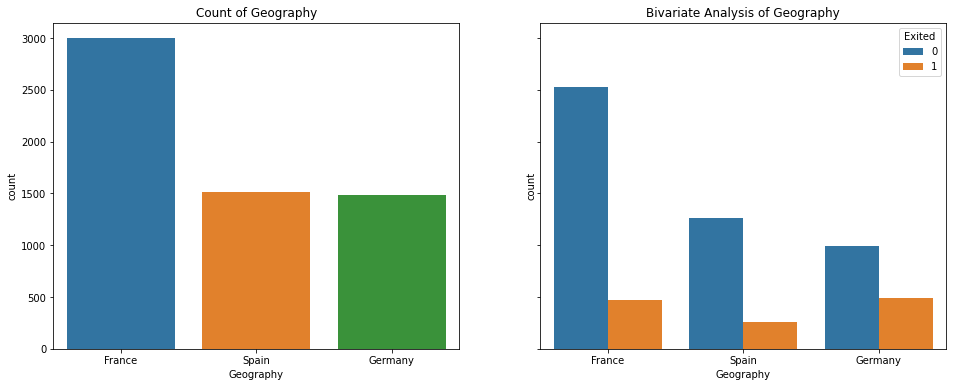

France     2998
Spain      1517
Germany    1485
Name: Geography, dtype: int64


 Cross Tabular Data 
Exited        0    1  % Rate
Geography                   
France     2530  468    84.4
Germany     990  495    66.7
Spain      1258  259    82.9

 Expected Values Table
Exited          0      1  % Rate
Geography                       
France     2387.4  610.6    79.6
Germany    1182.6  302.4    79.6
Spain      1208.0  309.0    79.6

Geography is correlated with Exited with a p-value of  0.0000
_________________________________________________________________________


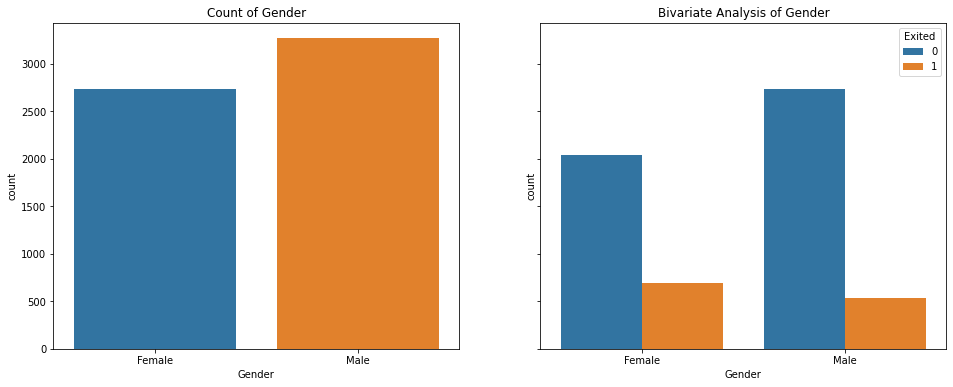

Male      3269
Female    2731
Name: Gender, dtype: int64


 Cross Tabular Data 
Exited     0    1  % Rate
Gender                   
Female  2043  688    74.8
Male    2735  534    83.7

 Expected Values Table
Exited       0      1  % Rate
Gender                       
Female  2174.8  556.2    79.6
Male    2603.2  665.8    79.6

Gender is correlated with Exited with a p-value of  0.0000
_________________________________________________________________________


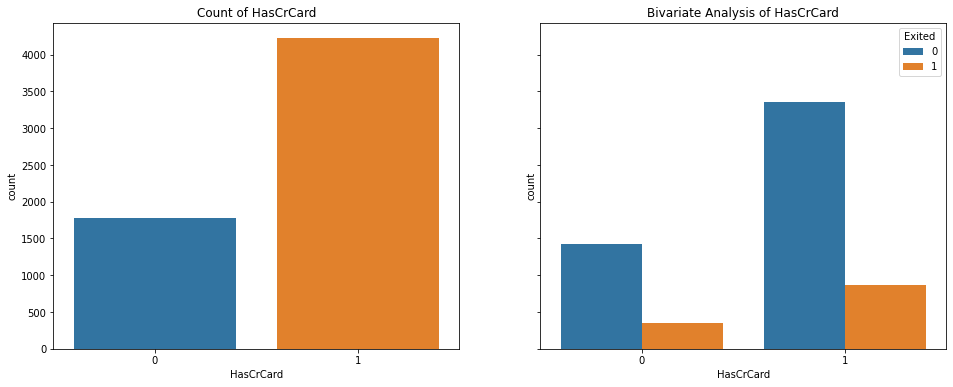

1    4224
0    1776
Name: HasCrCard, dtype: int64


 Cross Tabular Data 
Exited        0    1  % Rate
HasCrCard                   
0          1419  357    79.9
1          3359  865    79.5

 Expected Values Table
Exited          0      1  % Rate
HasCrCard                       
0          1414.3  361.7    79.6
1          3363.7  860.3    79.6

HasCrCard is not correlated with Exited with a p-value of  0.7674
_________________________________________________________________________


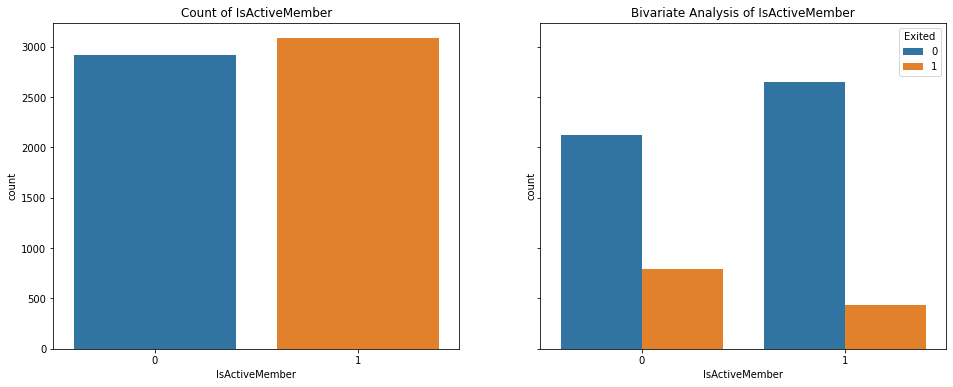

1    3084
0    2916
Name: IsActiveMember, dtype: int64


 Cross Tabular Data 
Exited             0    1  % Rate
IsActiveMember                   
0               2125  791    72.9
1               2653  431    86.0

 Expected Values Table
Exited               0      1  % Rate
IsActiveMember                       
0               2322.1  593.9    79.6
1               2455.9  628.1    79.6

IsActiveMember is correlated with Exited with a p-value of  0.0000
_________________________________________________________________________


In [13]:
for feature in categorical_vars:
  categorical_eda(training_data, feature, 'Exited') # univariate and bivariate analysis of categorical variables

for feature in binary_vars:
  categorical_eda(training_data, feature, 'Exited') # univariate and bivariate analysis of binary variables

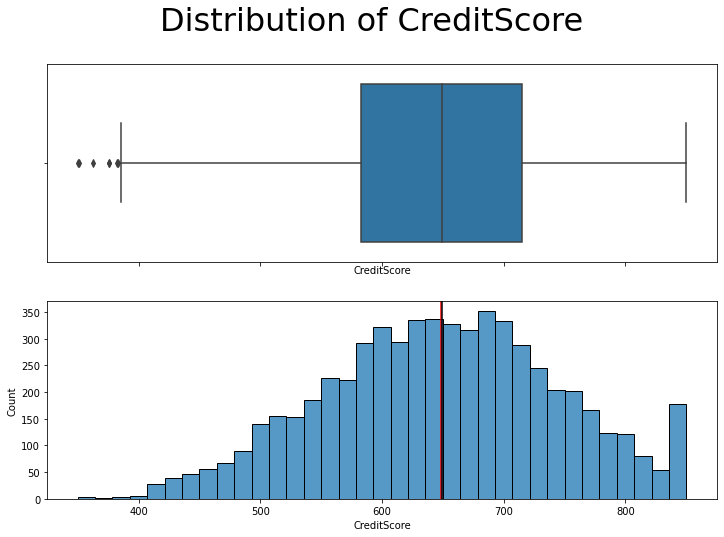

There are 7 lower outliers and 0 upper outliers.
The median of CreditScore is 649.0.
The mean of CreditScore is  648.30
The lower whisker of CreditScore is 385.0
The upper whisker of CreditScore is 913.0
The minimum of CreditScore is 350
The maximum of CreditScore is 850
The standard deviation of CreditScore is  96.54
----------------------------------------------------------


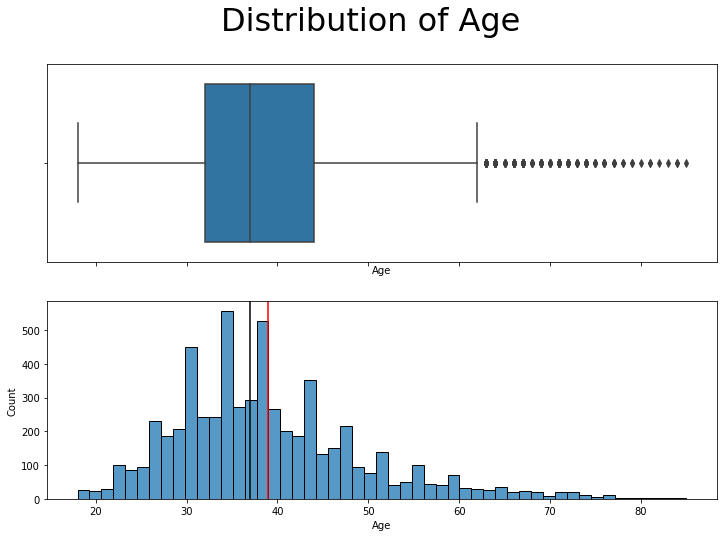

There are 0 lower outliers and 215 upper outliers.
The median of Age is 37.0.
The mean of Age is  38.98
The lower whisker of Age is 14.0
The upper whisker of Age is 62.0
The minimum of Age is 18
The maximum of Age is 85
The standard deviation of Age is  10.44
----------------------------------------------------------


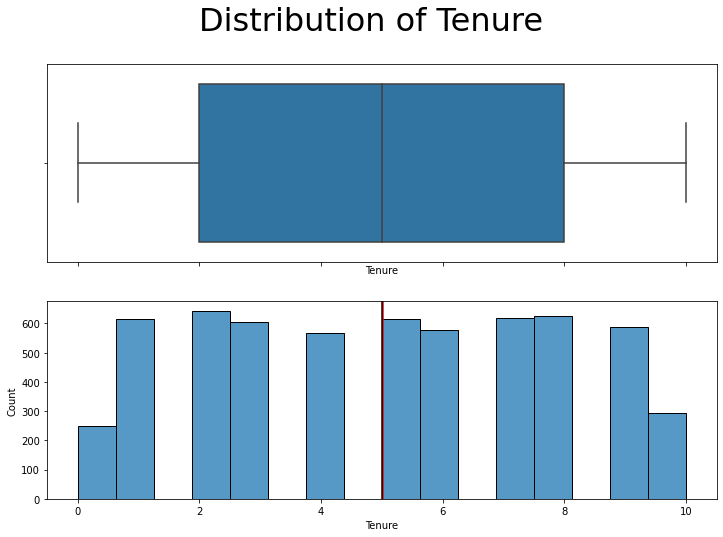

There are 0 lower outliers and 0 upper outliers.
The median of Tenure is 5.0.
The mean of Tenure is  5.02
The lower whisker of Tenure is -7.0
The upper whisker of Tenure is 17.0
The minimum of Tenure is 0
The maximum of Tenure is 10
The standard deviation of Tenure is  2.90
----------------------------------------------------------


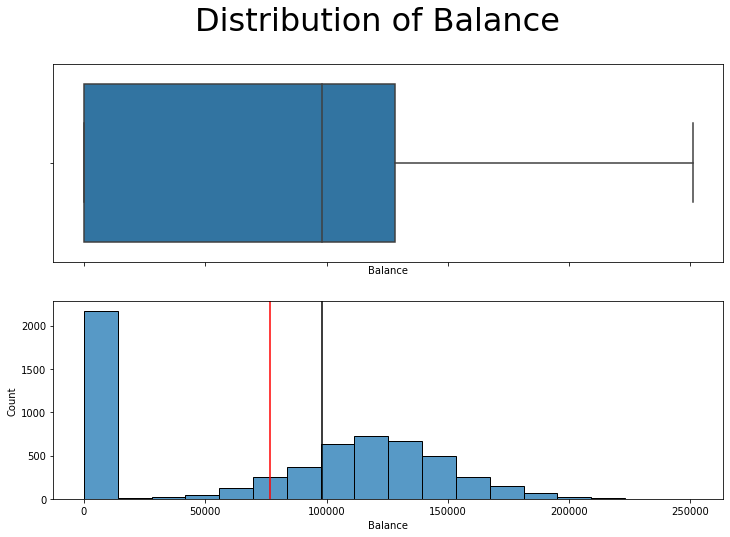

There are 0 lower outliers and 0 upper outliers.
The median of Balance is 98269.59.
The mean of Balance is  76911.42
The lower whisker of Balance is -192394.57125000004
The upper whisker of Balance is 320657.61875
The minimum of Balance is 0.0
The maximum of Balance is 250898.09
The standard deviation of Balance is  62747.99
----------------------------------------------------------


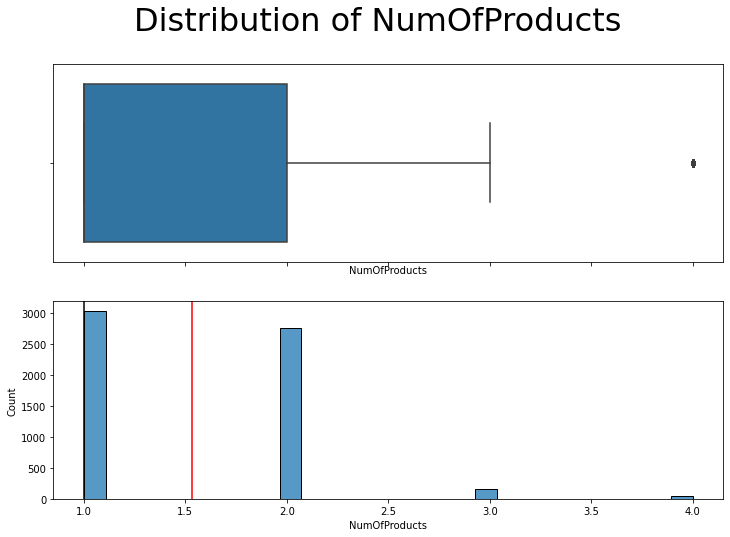

There are 0 lower outliers and 43 upper outliers.
The median of NumOfProducts is 1.0.
The mean of NumOfProducts is  1.53
The lower whisker of NumOfProducts is -0.5
The upper whisker of NumOfProducts is 3.5
The minimum of NumOfProducts is 1
The maximum of NumOfProducts is 4
The standard deviation of NumOfProducts is  0.59
----------------------------------------------------------


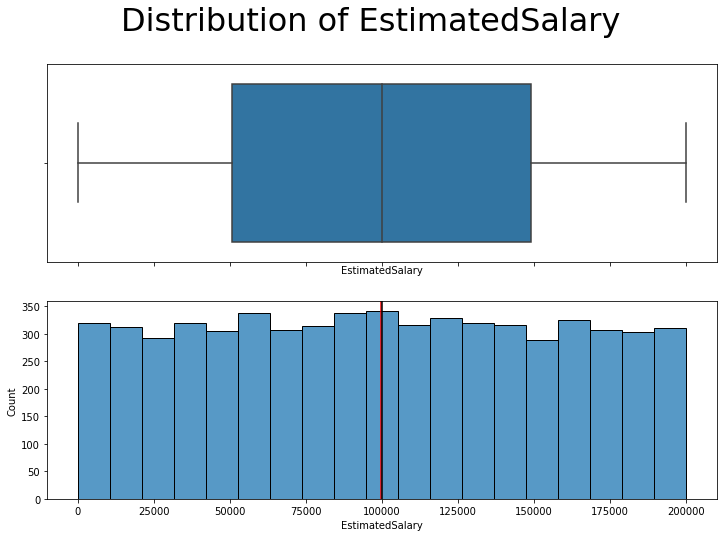

There are 0 lower outliers and 0 upper outliers.
The median of EstimatedSalary is 100145.565.
The mean of EstimatedSalary is  99787.59
The lower whisker of EstimatedSalary is -96244.01
The upper whisker of EstimatedSalary is 295826.29
The minimum of EstimatedSalary is 11.58
The maximum of EstimatedSalary is 199992.48
The standard deviation of EstimatedSalary is  57289.10
----------------------------------------------------------


In [14]:
numeric_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] # listing the numeric variables

for feature in numeric_vars:
  numerical_eda(training_data, feature) # boxplots and histograms of the numeric features

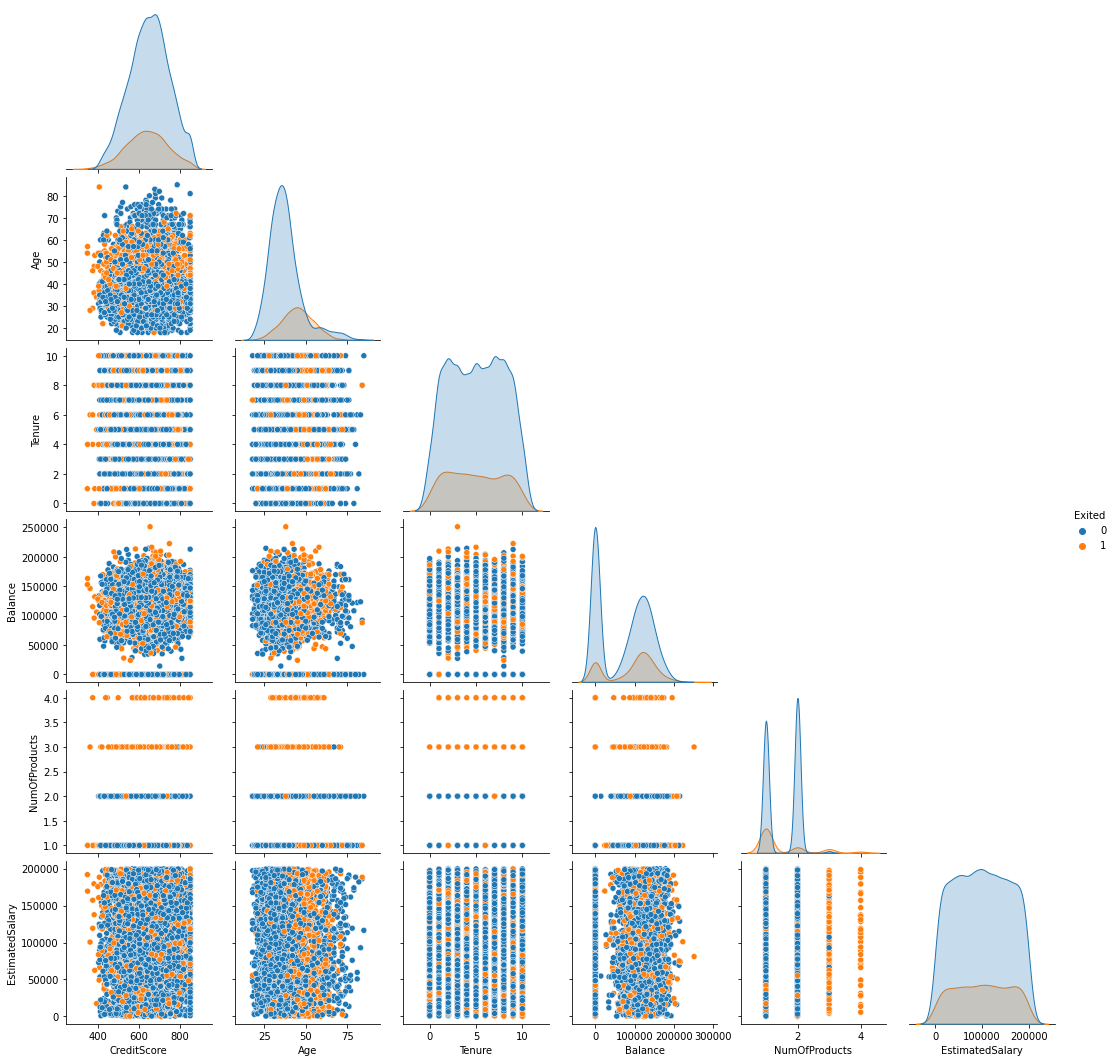

In [15]:
sns.pairplot(training_data, vars=numeric_vars, hue='Exited', corner=True); # pair plot of the numeric variables

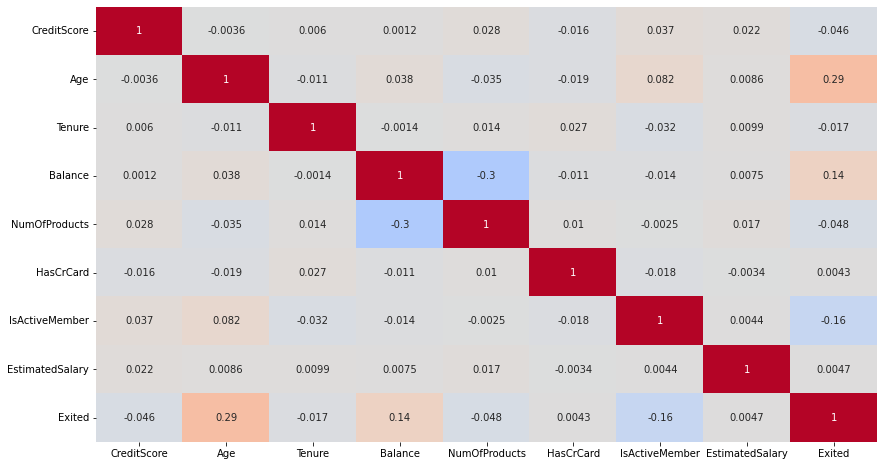

In [16]:
plt.figure(figsize=(14,8)) # makes the plot larger
sns.heatmap(training_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False); # correlation heatmap of the training data
plt.show() # shows the plot

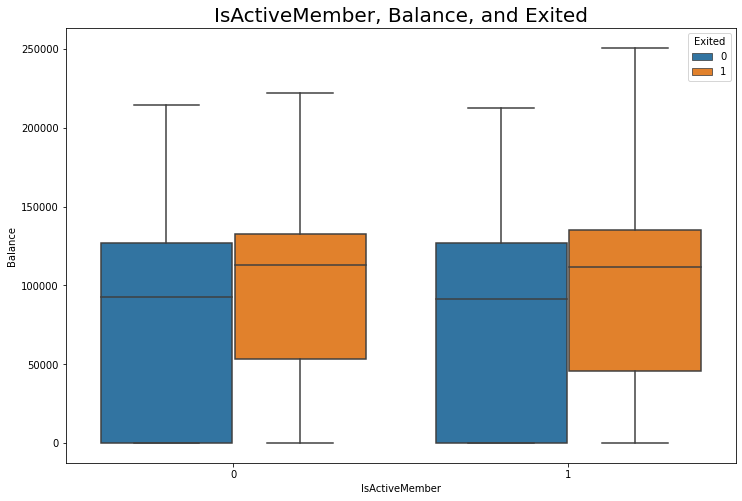

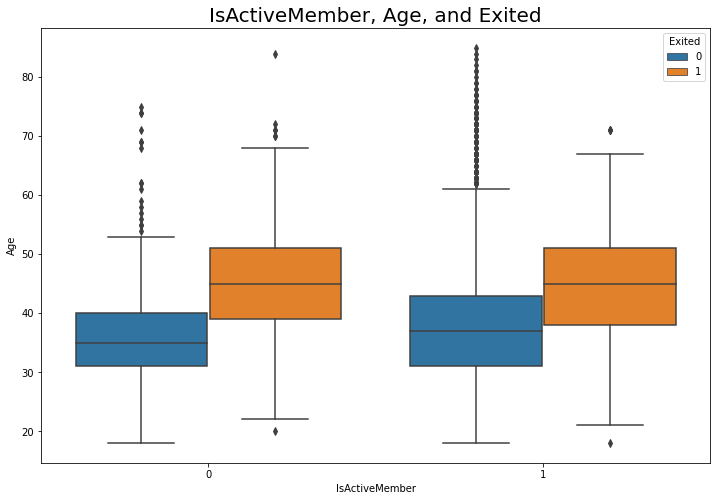

<Figure size 720x720 with 0 Axes>

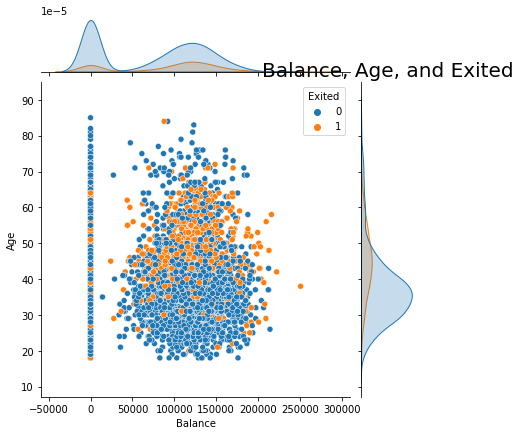

In [17]:
# Looking at some of the strongest predictors together: IsActiveMember, Balance, and Age with Exited
plt.figure(figsize=(12,8)) # slightly larger plot
plt.title('IsActiveMember, Balance, and Exited', fontdict={'fontsize':20}) # sets title
sns.boxplot(x=training_data['IsActiveMember'], y=training_data['Balance'], hue=training_data['Exited']); 
    # boxplot including 3 variables
plt.show() # shows the plot

plt.figure(figsize=(12,8)) # slightly larger plot
plt.title('IsActiveMember, Age, and Exited', fontdict={'fontsize':20}) # sets title
sns.boxplot(x=training_data['IsActiveMember'], y=training_data['Age'], hue=training_data['Exited']); 
    # boxplot including 3 variables
plt.show() # shows the plot

plt.figure(figsize=(10,10)) # slightly larger plot
sns.jointplot(x=training_data['Balance'], y=training_data['Age'], hue=training_data['Exited']); 
    # jointplot including 3 variables
plt.title('Balance, Age, and Exited', fontdict={'fontsize':20}) # sets title
plt.show() # shows the plot

## Exploratory Data Analysis Results

**Geography**  
There are three values: France, Spain, and Germany. The expected values for France and Spain are similar to the actual values, though there is some difference in the actual values. Customers from Germany have a higher probability of leaving the bank.   

**Gender**  
The difference in expected values and actual values is not significant enough to be a good predictor.  

**HasCrCard**  
There is almost no difference between the actual values and the expected values. It cannot indicate whether customers exited or not by itself.  

**IsActiveMember**  
This is one of the stronger predictors. If the customer has not been active lately, they are more likely to leave the bank. This makes sense.  

**CreditScore**  
CreditScore has a mostly normal distribution with a slight left tail. There are 7 lower outliers. It is not a good indicator of which customers exit the bank.  

**Age**  
Age has a mostly normal distribution with a slight right tail. There are 215 outliers out of 6000 observations. Customers who have exited the bank tended to be a little older than people who didn't leave. Age was the most correlated feature with Exited at a moderate .29 correlation.  

**Tenure**  
Tenure has a uniform distribution with slightly fewer customers at the extreme values. There are no outliers.  It is not correlated with other features.  

**Balance**  
Balance shows many customers with 0 balance. Excluding the large group at 0, the feature is normally distributed. There are no outliers. It is one of the stronger predictors of the target variable, though that is only with a positive correlation of 0.14 which is not particularly strong ordinarily.  

**NumOfProducts**  
The majority of custers have 1 or 2 purchased number of products. Some have 3 or 4 with 4 products being the outlier in the distribution. There is a light negative correlation with Balance (-0.3), but it is not correlated with the target variable.  

**EstimatedSalary**  
EstimatedSalary has a uniform distribution with no outliers. It has no correlation with other features or with the target variable.  

**Exited**  
This is the target variable. There are approximately 20% of customers who leave the bank so the dataset is slightly unbalanced. It would be good to use oversampling to balance the dataset.   

**SUMMARY**  
Looking at the graphs of the strongest indicators together, Age is the best overall predictor even though it is not a strong predictor.

# Preprocessing the Data

We will create a pipeline with missing value treatment for all columns, scaling between 0 and 1 for numeric variables, and one hot encoding for the categorical variables. 

The data needs to be fed into the models as tensors, not numpy arrays so we will convert them into tensors. However, we will not do this in the pipeline as we need to change the labels into tensors too.  

While we do not have any missing values in the training data, we do not know that the validation or test sets or any future data will not contain missing values. We will impute the median for numeric features and the most frequent value for categorical features.  

While we can scale the features in many ways, we will scale between 0 and 1 to match the bounds of the categorical variables.  

Outliers will not be removed or clipped because the outliers are not particularly extreme and still represent customers with a reasonable probability of occurrence.

**Pipeline Plan**
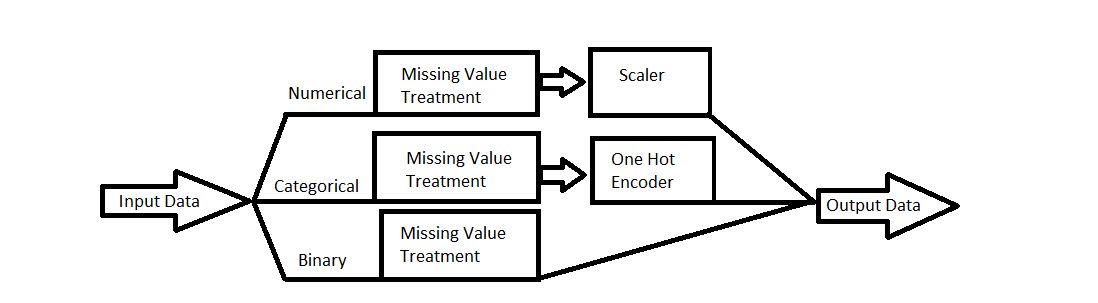

In [18]:
# Creating Pipelines to transform the data

numeric_transformer = Pipeline(steps=[('numeric_imputer', SimpleImputer(strategy='median')), # missing value treatment
                                      ('numeric_scaler', MinMaxScaler())]) # scaling between 0 and 1

categorical_transformer=Pipeline(steps=[('categorical_imputer',SimpleImputer(strategy='most_frequent')),#missing value treatment
                                          ('one_hot_encoder', OneHotEncoder())]) # one hot encoding

binary_transformer = Pipeline(steps=[('binary_imputer', SimpleImputer(strategy='most_frequent'))]) # missing value treatment

feature_engineering = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_vars), # numeric transformer
                                                      ('binary', binary_transformer, binary_vars), # transforms binary variables
                                                      ('categorical', categorical_transformer, categorical_vars)], # cagorical
                                                    remainder='passthrough') # features pass through if unused

data_transformation = Pipeline(steps=[('feat_eng', feature_engineering)]) # creates a pipeline to transform the data

In [19]:
def pandas_oversampler(X_train, y_train):
  """Oversamples a dataframe and converts it back to pandas with the previous column names
    This is specifically so that the X_train can go through the pipeline without an error"""
  X_train2 = X_train.copy() # doesn't change the original dataframe by accident
  y_train2 = y_train.copy() # doesn't change the original dataframe by accident

  random_oversampler = RandomOverSampler(random_state=7) # initializing for oversampling
  X_train_oversampled, y_train_oversampled = random_oversampler.fit_resample(X_train2, y_train2) # oversamples the data

  column_names = X_train2.columns # gets the column names from the original pandas dataframe
  X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=column_names) 
    # converts the oversampled nparray into a pandas dataframe with the original column names

  return X_train_oversampled, y_train_oversampled 
    # returns the oversampled data, X_train as pandas dataframe and y_train as nparray

In [20]:
X_train_oversampled, y_train_oversampled = pandas_oversampler(X_train, y_train) 
    # oversamples the data, X_train returned as pandas dataframe

print(f'The number of samples in y_train is {y_train.shape[0]}.') # number of samples in original training data
print(f'The number of samples in y_train_oversampled is {y_train_oversampled.shape[0]}.') # samples in oversampled training data

The number of samples in y_train is 6000.
The number of samples in y_train_oversampled is 9556.


In [21]:
# Transforming the Training, Validation, and Test data
X_train_oversampled = data_transformation.fit_transform(X_train_oversampled) 
    # fitting the pipeline to the training data, transforming the training data
X_val = data_transformation.transform(X_val) # transforming the validation data
X_test = data_transformation.transform(X_test) # transforming the test data

# How many features will there be after going through the pipeline?
print(f'There are {X_train_oversampled.shape[1]} features after the transformation through the pipeline.')

There are 13 features after the transformation through the pipeline.


In [22]:
# Function to convert everything to tensors
def make_tensor(X, y):
  """Returns the features and labels as tensors"""
  X = np.asarray(X).astype('float32') # converts features to float32
  X = tf.convert_to_tensor(X) # converts features to tensor
  y = np.asarray(y).astype('float32') # converts labels to float32
  y = tf.convert_to_tensor(y) # converts labels to tensor

  return X, y # returns the features and labels

#Metrics for Evaluation

This is a binary classification problem so we can look at Accuracy, F1 Score, Recall, or Precision as our evaluation metric.  

The purpose of the model is to predict churn because the bank is concerned about customers who leave, suggesting that we should reduce false negatives (customers who leave the bank, but the model suggested they would not exit). This could be done with Recall or F1 Score. We will choose Recall as our evaluation metric.

Apart from this, we will also use ROC-AUC to determine the optimal threshold to preserve as much Precision as we can. 



In [23]:
def cm_scoring_eval(model, X_train, y_train, X_test, y_test, threshold=.5, return_scores=False):
    """This function shows a confusion matrix and the scores (accuracy, recall, precision, specificity, and f1).
    The default value for threshold is 0.5. There is an option to return the scores, specifically for the test data."""
    
    # Graph Structure
    fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=False, figsize=(12,4)) # creates two plots along one row
    train_ax.set_title(f'Training Set Evaluation', fontsize=22) # titles the plot for the training evaluation
    test_ax.set_title(f'Test Set Evaluation', fontsize=22) # titles the plot for the test evaluation
    fig.text(0.5, 0.04, 'PREDICTED                                                    PREDICTED', # extra long for positioning
             ha='center', va='center', fontdict={'fontsize':16}) # manual x labels
    fig.text(0.06, 0.5, 'ACTUAL', ha='center', va='center', rotation='vertical', fontdict={'fontsize':16}) # manual y label
    
    # Confusion Matrix for Training Set
    predictions_train = np.round(model.predict(X_train) > threshold) 
        # predicts the classes based on probabilities above a threshold
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, predictions_train).ravel() 
        # confusion matrix numbers, gives more control over formatting and calculations
    total_train = tn_train + fp_train + fn_train + tp_train # total number of observations, used for percentages
    labels_train = np.array([["{0:0.0f}".format(tn_train) + "\nTrue Negative" + "\n{0:.2%}".format(tn_train/total_train),
                             "{0:0.0f}".format(fp_train) + "\nFalse Positive" + "\n{0:.2%}".format(fp_train/total_train)], 
                            ["{0:0.0f}".format(fn_train) + "\nFalse Negative" + "\n{0:.2%}".format(fn_train/total_train),
                             "{0:0.0f}".format(tp_train) + "\nTrue Positive" + "\n{0:.2%}".format(tp_train/total_train)]])
        # Labels is used to format the cells of the heatmap to include the values, classifications, and overall percentages
    sns.heatmap([[tp_train,fn_train],[fp_train,tn_train]], annot=labels_train, fmt='',cmap="seismic", ax=train_ax, cbar=False) 
        # heatmap of confusion matrix for training set
    
    # Confusion Matrix for Test Set
    predictions_test = np.round(model.predict(X_test) > threshold) 
        # predicts the classes based on probabilities above a threshold
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, predictions_test).ravel() 
        # confusion matrix numbers, gives more control over formatting and calculations
    total_test = tn_test + fp_test + fn_test + tp_test # total number of observations, used for percentages
    labels_test = np.array([["{0:0.0f}".format(tn_test) + "\nTrue Negative" + "\n{0:.2%}".format(tn_test/total_test),
                             "{0:0.0f}".format(fp_test) + "\nFalse Positive" + "\n{0:.2%}".format(fp_test/total_test)], 
                            ["{0:0.0f}".format(fn_test) + "\nFalse Negative" + "\n{0:.2%}".format(fn_test/total_test),
                             "{0:0.0f}".format(tp_test) + "\nTrue Positive" + "\n{0:.2%}".format(tp_test/total_test)]])
        # Labels is used to format the cells of the heatmap to include the values, classifications, and overall percentages
    sns.heatmap([[tp_test,fn_test],[fp_test,tn_test]], annot=labels_test, fmt='',cmap="seismic", ax=test_ax, cbar=False) 
        # heatmap of confusion matrix for test set     
    plt.show() # to show heatmap before classification report
    
    # Scoring, based on values in the confusion matrix
    cm_train = [tn_train, fp_train, fn_train, tp_train, 'Train'] # values to be loaded in loop
    cm_test = [tn_test, fp_test, fn_test, tp_test, 'Test'] # values to be loaded in loop
    scoring_db = pd.DataFrame(columns=['Accuracy', 'Recall', 'Specificity', 'Precision', 'F1 Score']) # sets column names
    
    for tn, fp, fn, tp, name in cm_train, cm_test: # loop to calculate the metrics and add them to a DataFrame
        cm_accuracy = (tn+tp)/(tn+tp+fp+fn) # calculates accuracy
        cm_recall = tp/(tp+fn) # calculates recall
        cm_spec = tn/(tn+fp) # calculates specificity
        cm_prec = tp/(tp+fp) # calculates precision
        cm_f1 = 2*cm_recall*cm_prec / (cm_recall + cm_prec) # calculates f1 score
        scoring_db.loc[name] = ['{0:.2%}'.format(cm_accuracy), np.round(cm_recall, 2), np.round(cm_spec, 2),
                                np.round(cm_prec, 2), np.round(cm_f1, 2)]
            # adds the metrics to the DataFrame indexed using the strings in the loaded lists, values are formatted
    
    display(scoring_db) # prints a nice display of the DataFrame
    
    if return_scores == True: # to have a returned list of the scores
        return scoring_db.loc['Test'] # returns slice of Test row
    

def threshold_calc(model, X, y):
    """This function graphs the ROC-AUC curve and calculates the optimal threshold with various methods."""
    # ROC curve is useful for binary classification so it is used here
    fpr, tpr, thresholds = roc_curve(y, model.predict(X)) # data for the ROC graph
    roc_auc_scoring = roc_auc_score(y, model.predict(X)) # area under the ROC graphed curve
    # Plotting Details
    plt.figure(figsize=(10,6)) # somewhat larger plot
    plt.title('Receiver Operating Characteristic Graph', fontdict={'fontsize':18}) # enlarged title
    plt.xlabel('False Positive Rates', fontdict={'fontsize':16}) # medium font x-axis label
    plt.ylabel('True Positive Rates', fontdict={'fontsize':16})  # medium font y-axis label
    plt.xlim([0, 1]) # length of x-axis
    plt.ylim([0, 1.01]) # length of y-axis 
    plt.plot([0,1],[0,1], 'r--') # plots the random classifier
    plt.plot(fpr, tpr, label=f'Area under the curve: {roc_auc_scoring : 0.2f}') # plots the model classifier
    plt.legend(loc=4, fontsize='large') # lower right location, using location codes
    plt.show() # shows the plot
    
    # OPTIMAL THRESHOLD TO MAXIMIZE RECALL
        # Method 1: Finding the optimal threshold value using TPR - FPR from the ROC-AUC data
    best_thresh = np.argmax(tpr - fpr) # finds index of largest TPR-FPR
    optimal_thresh = thresholds[best_thresh] # uses the index to get the threshold
    print(f'The optimal threshold using the ROC-AUC is {optimal_thresh}') # prints the threshold
        # Method 2: Finding the optimal threshold value using the precision-recall curve
    precisions, recalls, thresholds=precision_recall_curve(y,model.predict(X)) #recall, precision for all thresholds
    plt.figure(figsize=(10,6))
    plt.title('Precision-Recall Curve', fontdict={'fontsize':18}) # enlarged title
    plt.xlabel('Threshold', fontdict={'fontsize':16}) # medium font x-axis label
    plt.xlim([0, 1]) # length of x-axis
    plt.ylim([0, 1.01]) # length of y-axis
    plt.plot(thresholds, precisions[:-1], 'r-.', label='Precision') # plots the precision levels for each threshold
    plt.plot(thresholds, recalls[:-1], 'b-', label='Recall') # plots the recall levels for each threshold
    plt.minorticks_on() # enables minor ticks, easier to find specific thresholds
    plt.grid(which='minor', color='white', linestyle='--') # matches style of major ticks except change in linestyle
    plt.show() # shows the plot


def loss_curve(model_training_info):
  """Creates a plot of the loss of the training data vs validation data across the epochs"""
  # Creating the DataFrame
  model_history  = pd.DataFrame(model_training_info.history) # creates the dataframe of training information
  model_history['epoch'] = model_training_info.epoch # adds a column for the number of epochs
  # Creates the learning curve plot
  plt.figure(figsize=(12,4))
  plt.xlabel('Epochs') # adds an x label to the plot
  plt.ylabel('Loss') # adds a y label to the plot
  plt.title('Learning Curve', fontdict={'fontsize':20}) # adds a title to the plot
  plt.plot(model_history['loss']) # plots the loss of the training data
  plt.plot(model_history['val_loss']) # plots the loss of the validation data
  plt.legend(('Training Data', 'Validation Data') , loc =0) # creates a legend in the upper right corner

In [24]:
model_comparison = pd.DataFrame(columns=['Accuracy', 'Recall', 'Specificity', 'Precision', 'F1 Score'])
    # creating an unpopulated dataframe with specified column names
    # we are specifically looking at the F1 score even though we include all of the metrics for reference

# Models

## Benchmark XGB Model

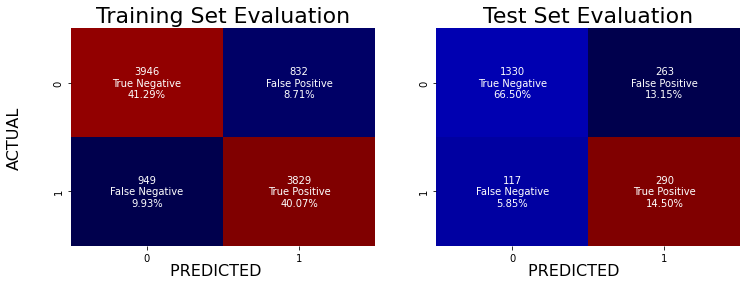

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,81.36%,0.80,0.83,0.82,0.81
Test,81.00%,0.71,0.83,0.52,0.60


In [25]:
xgb_model = XGBClassifier(random_state=7, eval_metric='logloss') 
    # creating an Extreme Gradient Boosting model to use as a benchmark
xgb_model.fit(X_train_oversampled, y_train_oversampled) # fitting the model with the training data
xgb_scores = cm_scoring_eval(xgb_model, X_train_oversampled, y_train_oversampled, X_test, y_test, return_scores=True) 
    # evaluating the model on the test data and returning a score
model_comparison.loc['XGB'] = xgb_scores # adding scores to the comparison dataframe

### Benchmark Results

The model is slightly overfit, particularly seen through the difference in Precision. However, the Accuracy and Recall are close between the training and the test sets.

## Simple Sequential Model

In [26]:
# Converting the Data into Tensors
X_train_oversampled, y_train_oversampled = make_tensor(X_train_oversampled, y_train_oversampled) # training data
X_val, y_val = make_tensor(X_val, y_val) # validation data
X_test, y_test = make_tensor(X_test, y_test) # testing data

In [27]:
# Building a simple neural network with two hidden layers
simple_model = Sequential() # creates a Sequential neural network
simple_model.add(Dense(units=32, input_dim=X_train_oversampled.shape[1], activation='relu')) 
  #input_dim is 13 based on the earlier dimension check, creates hidden layer with 32 nodes
simple_model.add(Dense(units=32, activation='relu')) # 2nd hidden layer, 32 nodes
simple_model.add(Dense(units=1, activation='sigmoid')) # output layer with 1 node
simple_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()]) 
  # sets the loss function, optimizer, and evaluation metric and compiles the model so it can be used
simple_model.summary() # shows the structure of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [28]:
learning_data = simple_model.fit(X_train_oversampled, y_train_oversampled, epochs=120, 
                                 batch_size=64, validation_data=(X_val,y_val)) 
  # trains the model, iterating over all the training samples 120 times

Epoch 1/120
150/150 [==============================] - 2s 5ms/step - loss: 0.6578 - recall: 0.5293 - val_loss: 0.5876 - val_recall: 0.5245
Epoch 2/120
150/150 [==============================] - 0s 2ms/step - loss: 0.5913 - recall: 0.6812 - val_loss: 0.5821 - val_recall: 0.6373
Epoch 3/120
150/150 [==============================] - 0s 2ms/step - loss: 0.5626 - recall: 0.7168 - val_loss: 0.5835 - val_recall: 0.6936
Epoch 4/120
150/150 [==============================] - 0s 2ms/step - loss: 0.5490 - recall: 0.7250 - val_loss: 0.5693 - val_recall: 0.6985
Epoch 5/120
150/150 [==============================] - 0s 3ms/step - loss: 0.5316 - recall: 0.7386 - val_loss: 0.4969 - val_recall: 0.6127
Epoch 6/120
150/150 [==============================] - 0s 2ms/step - loss: 0.5105 - recall: 0.7518 - val_loss: 0.5364 - val_recall: 0.7059
Epoch 7/120
150/150 [==============================] - 0s 2ms/step - loss: 0.4951 - recall: 0.7518 - val_loss: 0.5111 - val_recall: 0.6985
Epoch 8/120
150/150 [======

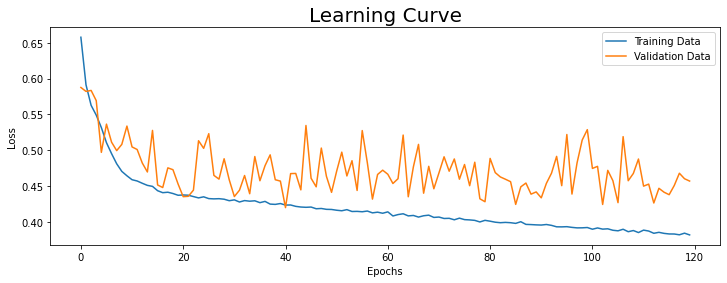

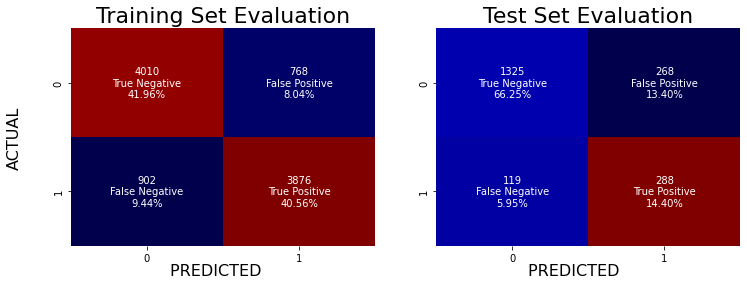

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,82.52%,0.81,0.84,0.83,0.82
Test,80.65%,0.71,0.83,0.52,0.60


In [29]:
loss_curve(learning_data) # plots the learning curve
print('\n\n') # additional separation in the output
simple_scores = cm_scoring_eval(simple_model, X_train_oversampled, y_train_oversampled, X_test, y_test, return_scores=True) 
  # shows the confusion matrices for the training and test evaluation, records the test scores
model_comparison.loc['Simple'] = simple_scores # adds the score to the model comparison dataframe

### Notes about the Simple Model

The model is definitely overfit. The evaluation of the test data yields worse results than the training data. The learning curve also indicates an overfit model. We will add regularization via dropout in the next model iteration.

This model is the same as the benchmark.

## Second Model

In [30]:
# Building the second neural network with one hidden layer
second_model = Sequential() # creates another Sequential neural network
second_model.add(Dense(units=32, input_dim=X_train_oversampled.shape[1], activation='relu'))
  #input_dim is 13 based on the earlier dimension check, creates hidden layer with 32 nodes
second_model.add(Dropout(.25)) # adds dropout to the first hidden layer to add regularization
second_model.add(Dense(units=32, activation='relu')) # 2nd hidden layer, 32 nodes
second_model.add(Dropout(.25)) # adds dropout to the second hidden layer to add regularization
second_model.add(Dense(units=1, activation='sigmoid')) # output layer with 1 node
second_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()]) 
  # sets the loss function, optimizer, and evaluation metric and compiles the model so it can be used
second_model.summary() # shows the structure of the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                448       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [31]:
learning_data2 = second_model.fit(X_train_oversampled, y_train_oversampled, epochs=120, 
                                  batch_size=64, validation_data=(X_val,y_val)) 
  # trains the model, iterating over all the training samples 120 times

Epoch 1/120
150/150 [==============================] - 2s 5ms/step - loss: 0.6665 - recall_1: 0.5419 - val_loss: 0.6133 - val_recall_1: 0.6005
Epoch 2/120
150/150 [==============================] - 0s 3ms/step - loss: 0.6229 - recall_1: 0.6392 - val_loss: 0.6296 - val_recall_1: 0.6740
Epoch 3/120
150/150 [==============================] - 0s 3ms/step - loss: 0.6087 - recall_1: 0.6697 - val_loss: 0.5957 - val_recall_1: 0.6348
Epoch 4/120
150/150 [==============================] - 0s 3ms/step - loss: 0.5902 - recall_1: 0.6854 - val_loss: 0.5862 - val_recall_1: 0.6422
Epoch 5/120
150/150 [==============================] - 0s 3ms/step - loss: 0.5814 - recall_1: 0.7036 - val_loss: 0.5708 - val_recall_1: 0.6544
Epoch 6/120
150/150 [==============================] - 0s 3ms/step - loss: 0.5636 - recall_1: 0.7172 - val_loss: 0.5306 - val_recall_1: 0.6471
Epoch 7/120
150/150 [==============================] - 0s 3ms/step - loss: 0.5454 - recall_1: 0.7233 - val_loss: 0.5176 - val_recall_1: 0.6495

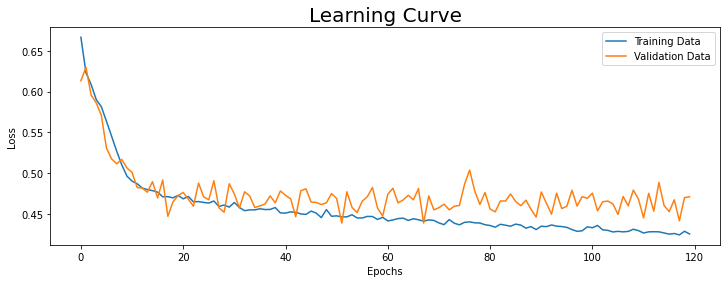

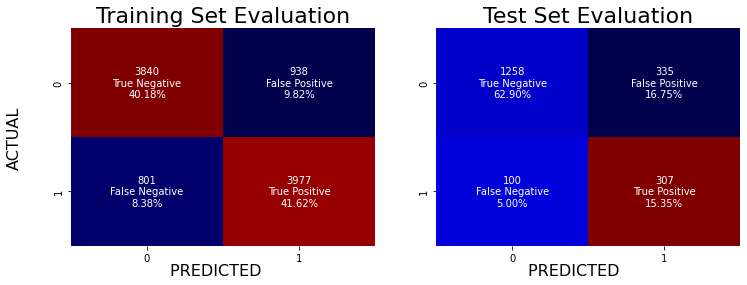

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,81.80%,0.83,0.80,0.81,0.82
Test,78.25%,0.75,0.79,0.48,0.59


In [32]:
loss_curve(learning_data2) # plots the learning curve
print('\n\n') # additional separation in the output
second_scores = cm_scoring_eval(second_model, X_train_oversampled, y_train_oversampled, X_test, y_test, return_scores=True) 
  # shows the confusion matrices for the training and test evaluation, records the test scores
model_comparison.loc['Second'] = second_scores # adds the score to the model comparison dataframe

### Notes about the Second Model

This model has performance with the training data as the simple model. However, the dropout regularizes the model well. The test data and validation data indicate that the model is only slightly overfit. There is still a large gap between the precision of the training and test data we will fix that using ROC-AUC.

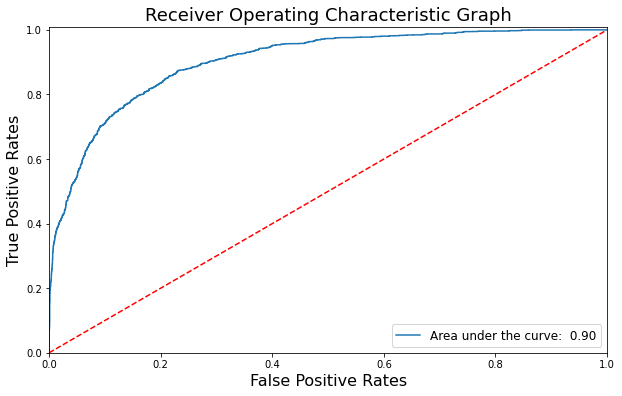

The optimal threshold using the ROC-AUC is 0.4550323784351349


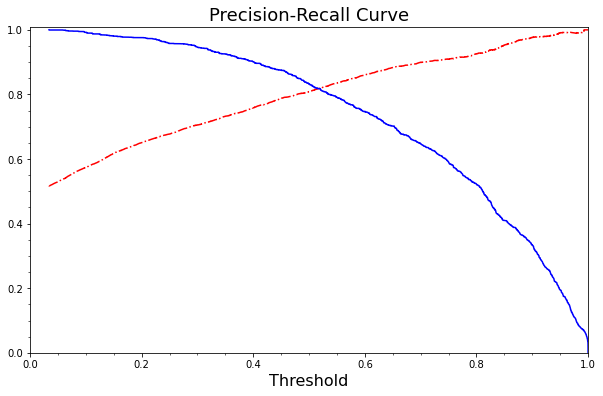

In [33]:
threshold_calc(second_model, X_train_oversampled, y_train_oversampled) # checking the ROC-AUC

### Notes about the ROC-AUC

The optimal threshold is about .50 which is the default value. Even so, we can explore what happens by trying some other thresholds and looking at the results.


Evaluation with Threshold = 0.3:



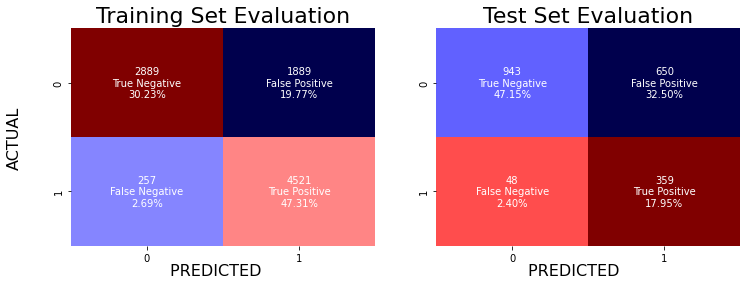

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,77.54%,0.95,0.60,0.71,0.81
Test,65.10%,0.88,0.59,0.36,0.51



Evaluation with Threshold = 0.4:



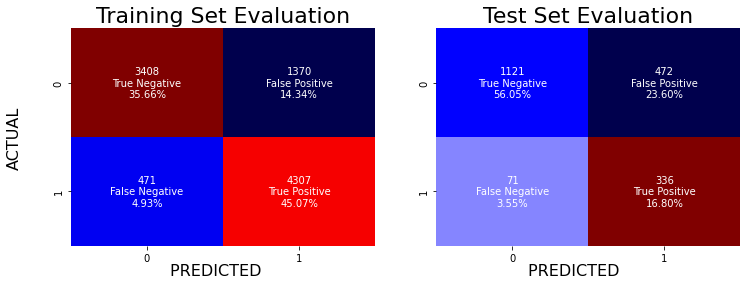

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,80.73%,0.90,0.71,0.76,0.82
Test,72.85%,0.83,0.70,0.42,0.55



Evaluation with Threshold = 0.5:



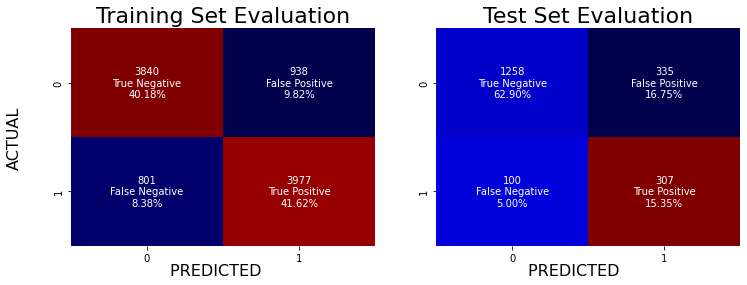

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,81.80%,0.83,0.80,0.81,0.82
Test,78.25%,0.75,0.79,0.48,0.59



Evaluation with Threshold = 0.6000000000000001:



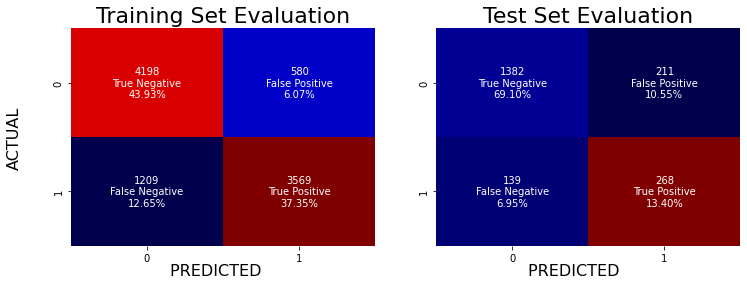

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,81.28%,0.75,0.88,0.86,0.8
Test,82.50%,0.66,0.87,0.56,0.6



Evaluation with Threshold = 0.7000000000000002:



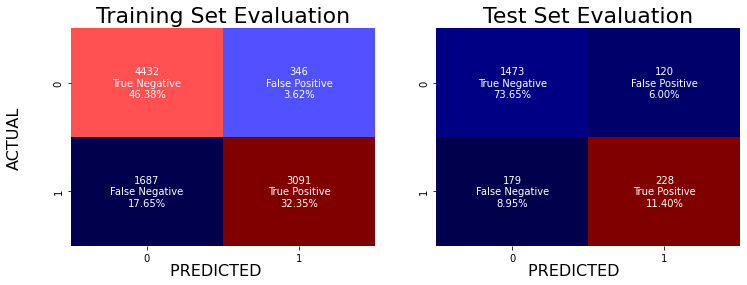

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,78.73%,0.65,0.93,0.90,0.75
Test,85.05%,0.56,0.92,0.66,0.60



Evaluation with Threshold = 0.8000000000000003:



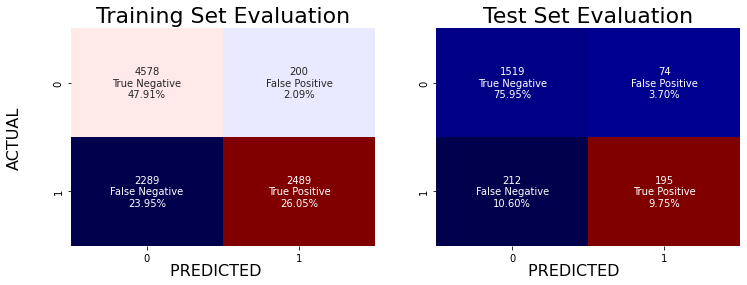

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,73.95%,0.52,0.96,0.93,0.67
Test,85.70%,0.48,0.95,0.72,0.58



Evaluation with Threshold = 0.9000000000000001:



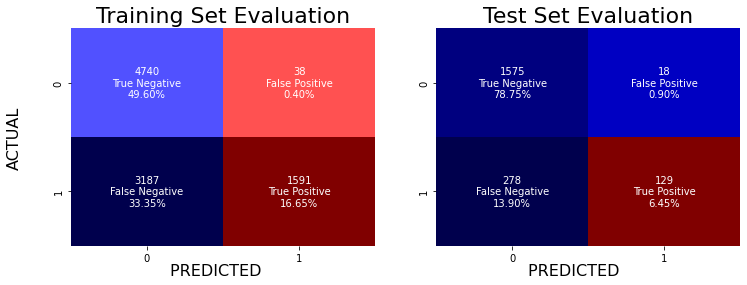

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,66.25%,0.33,0.99,0.98,0.50
Test,85.20%,0.32,0.99,0.88,0.47


In [34]:
for thresh in np.arange(.3, 1, .1): # tests thresholds from .3 to .9
  print(f'\nEvaluation with Threshold = {thresh}:\n') # states the current threshold
  cm_scoring_eval(second_model, X_train_oversampled, y_train_oversampled, X_test, y_test, threshold=thresh)
    # evaluates the training and testing data based on the thresholds

### Threshold Results:

| Threshold | Accuracy | Recall | Precision |  
| --- | --- | --- | --- |  
| 0.3 | 65.10% | .88 | .36 |
| 0.4 | 72.85% | .83 | .42 |
| 0.5 | 78.25% | .75 | .48 |
| 0.6 | 82.50% | .66 | .56 |
| 0.7 | 85.05% | .56 | .66 |
| 0.8 | 85.70% | .48 | .72 |
| 0.9 | 85.2% | .32 | .88 |

As we increase the threshold, the Recall drops and the Precision and the Accuracy rises. However, the Accuracy peaks at 86%. We need to have good Recall more than good Precision.

At .4 threshold, we gain more Recall while maintaining Precision as much as we can. However, the model has similar performance as the previous models.

## Third Model

This model will use hyperparameter tuning to improve the model.

In [35]:
# Defining a space to search with the hyperparameters
space = {'layers' : 1+hp.randint('layers', 4), # values from 1 to 4, hidden layers in model
         'units' : 8+hp.randint('units', 121), # values from 8 to 128, nodes per hidden layer
         'kern_init' : hp.choice('kern_init', ['truncated_normal', 'random_normal', 'glorot_normal', 
                                                 'glorot_uniform', 'he_normal', 'he_uniform']), 
                # selects a kernel_initializer
         'dropout' : hp.uniform('dropout', 0.01, 0.8), # values from .01 to .8, dropout rate after each hidden layer 
         'learning_rate' : hp.uniform('learning_rate', 0.2, 1), # values from .2 to 1, learning rate in SGD optimizer
         'decay_rate' : hp.uniform('decay_rate', 0.0001, .1), # values from .0001 to .1, decay rate to adjust the learning rate
         'momentum' : hp.uniform('momentum', 0.1, 1)} # selects a momentum from .1 to 1

def hyperopt_loss_func(params):
  """Loss function used in hyperopt.fmin(). """
  """Creates and optimizes a neural network with dynamic architecture using the given hyperparameters """
  optimized_model = Sequential() # instantiates the model
  optimized_model.add(Dense(units=params['units'], input_dim=X_train_oversampled.shape[1], # creates 1st hidden layer
                            activation='relu', kernel_initializer=params['kern_init'])) 
    # relu is the activation function used in all hidden layers
  optimized_model.add(Dropout(rate=params['dropout'])) # creates a dropout layer

  hidden_layer_count = 1 # counts the layer we already created
  while hidden_layer_count < params['layers']: # loop for any layers not yet created
      optimized_model.add(Dense(units=params['units'], activation='relu', kernel_initializer=params['kern_init'])) 
            # adds more hidden layers
      optimized_model.add(Dropout(params['dropout'])) # adds more dropout layers
      hidden_layer_count += 1 # adds 1 to the layer count

  optimized_model.add(Dense(units=1, activation='sigmoid')) # output layer with 1 node

  sgd = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'], momentum=params['momentum'], decay=params['decay_rate']) 
        # using SGD optimizer
  metric = PrecisionAtRecall(recall=.85) # tries to maximize the precision with a minimum recall of .85
  optimized_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[metric]) # compiles the model, now ready to use

  optimized_learning_curve = optimized_model.fit(X_train_oversampled, y_train_oversampled, epochs=100, batch_size=64,
                                                 validation_data=(X_val, y_val), verbose=0)  
    # fits the model to the oversampled training data
  metric_val = np.mean(optimized_learning_curve.history['val_loss'][-5:-1]) 
    # returns the average of the last few validation loss values

  return metric_val # returns a loss to be minimized in the Bayesian search method

best=fmin(fn=hyperopt_loss_func, space=space, algo=tpe.suggest, max_evals=50) # hyperopt optimization
print(best) # best model parameters

100%|██████████| 50/50 [32:08<00:00, 38.56s/it, best loss: 0.4353626146912575]
{'decay_rate': 0.0005108632582316875, 'dropout': 0.5550021594029729, 'kern_init': 2, 'layers': 2, 'learning_rate': 0.2271999911645065, 'momentum': 0.22558134974066724, 'units': 98}


In [36]:
kern_list = ['truncated_normal', 'random_normal', 'glorot_normal', 
             'glorot_uniform', 'he_normal', 'he_uniform'] # list of kernal initializers to reference

optimized_model = Sequential() # creates the third model
optimized_model.add(Dense(units=best['units'], input_dim=X_train_oversampled.shape[1], # adds the first hidden layer
                          activation='relu', kernel_initializer=kern_list[best['kern_init']])) # uses best found hyperparameters
optimized_model.add(Dropout(rate=best['dropout'])) # adds the first dropout layer

hidden_layer_count = 1 # layer count including the first layer
while hidden_layer_count < best['layers']: # creates more layers if there are additional layers in optimal architecture
  optimized_model.add(Dense(units=best['units'], activation='relu', kernel_initializer=kern_list[best['kern_init']])) 
    # adds more hidden layers
  optimized_model.add(Dropout(best['dropout'])) # adds more dropout layers
  hidden_layer_count += 1 # updates the hidden layer count

optimized_model.add(Dense(units=1, activation='sigmoid')) # output layer with 1 node

sgd = tf.keras.optimizers.SGD(learning_rate=best['learning_rate'], momentum=best['momentum'], decay=best['decay_rate']) 
    # adds a SGD optimizer
metric = PrecisionAtRecall(recall=.85) # tries to maximize the precision with a minimum recall of .85
optimized_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[metric]) # compiles the mode, now ready to use

optimized_learning_curve = optimized_model.fit(X_train_oversampled, y_train_oversampled, epochs=120, batch_size=64,
                                               validation_data=(X_val, y_val), verbose=1) # trains the model

Epoch 1/120
150/150 [==============================] - 1s 4ms/step - loss: 0.6527 - precision_at_recall_50: 0.5531 - val_loss: 0.5904 - val_precision_at_recall_50: 0.2613
Epoch 2/120
150/150 [==============================] - 0s 2ms/step - loss: 0.6184 - precision_at_recall_50: 0.5909 - val_loss: 0.6451 - val_precision_at_recall_50: 0.2774
Epoch 3/120
150/150 [==============================] - 0s 3ms/step - loss: 0.5979 - precision_at_recall_50: 0.6064 - val_loss: 0.5905 - val_precision_at_recall_50: 0.2889
Epoch 4/120
150/150 [==============================] - 0s 3ms/step - loss: 0.5810 - precision_at_recall_50: 0.6223 - val_loss: 0.4973 - val_precision_at_recall_50: 0.2970
Epoch 5/120
150/150 [==============================] - 0s 3ms/step - loss: 0.5685 - precision_at_recall_50: 0.6392 - val_loss: 0.5222 - val_precision_at_recall_50: 0.3023
Epoch 6/120
150/150 [==============================] - 0s 2ms/step - loss: 0.5518 - precision_at_recall_50: 0.6476 - val_loss: 0.5469 - val_preci


Confusion Matrix for the Validation Data:


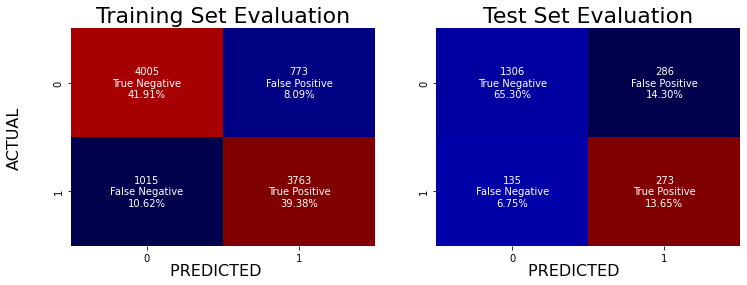

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,81.29%,0.79,0.84,0.83,0.81
Test,78.95%,0.67,0.82,0.49,0.56



Confusion Matrix for the Test Data:


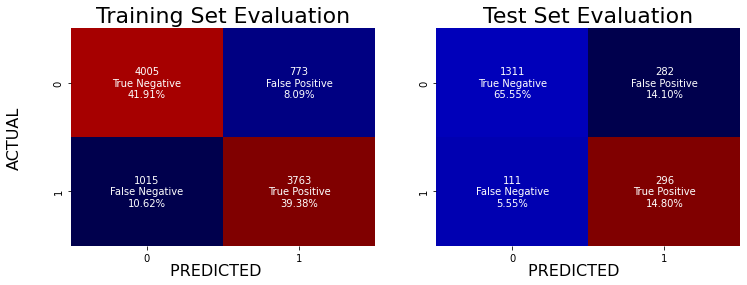

,Accuracy,Recall,Specificity,Precision,F1 Score
Train,81.29%,0.79,0.84,0.83,0.81
Test,80.35%,0.73,0.82,0.51,0.60


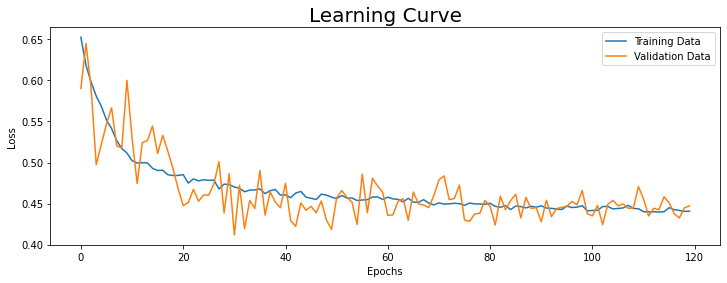

In [37]:
print('\nConfusion Matrix for the Validation Data:')
cm_scoring_eval(optimized_model, X_train_oversampled, y_train_oversampled, X_val, y_val) 
    # evaluates the model on the validation dataset
print('\nConfusion Matrix for the Test Data:')
third_model_score = cm_scoring_eval(optimized_model, X_train_oversampled, y_train_oversampled, 
                                    X_test, y_test, return_scores = True)  
  # evaluates the model on the test dataset, returns the score
model_comparison.loc['Third'] = third_model_score # adds the score to the model comparison dataframe
loss_curve(optimized_learning_curve) # plots the loss curve of the training and validation data

### Third Model Results

While we searched a space with many hyperparaters, even creating many model architectures in the process, we did not produce better results than the second model. The model is not as overfit as the simple model, but the precision is still considerably lower than the training data evaluation. The loss curve shows that the model is fairly balanced.

For similar results, we will choose the less complex model which is the second model as our final model.

# Conclusion

In [38]:
model_comparison # displays the model performances

,Accuracy,Recall,Specificity,Precision,F1 Score
XGB,81.00%,0.71,0.83,0.52,0.60
Simple,80.65%,0.71,0.83,0.52,0.60
Second,78.25%,0.75,0.79,0.48,0.59
Third,80.35%,0.73,0.82,0.51,0.60


The models, including the XGB benchmark, performed about the same. However, the second and third models were just slightly better.

Our selected model will be the second model and we will use a threshold of 0.4 to increase the Recall.

Accuracy: 72.85%  
Recall: 0.83  
Precision: 0.42  

With this model, we will identify most of the people who will leave. The cost to the model is the high false positive rate. This means that the bank will need to spend more money on people who may not actually be leaving to ensure that they don't leave. It also creates difficulty in identifying what measures are effective to stop people from leaving. The bank would need to collect additional information to evaluate their recovery efforts.

Unfortunately, it is difficult to say more than what we learned in the Exploratory Data Analysis about the driving factors because neural networks are blackbox algorithms.  

We only know that Age, IsActiveMember, Balance, and Geography are the most likely features to determine whether a customer will leave or not.

Based on a high percentage of customers leaving in the German bank branches, it would be wise to investigate those branches.

Younger customers tend to exit less than older members so it would be good to market to younger customers to create a base less likely to leave.